In [13]:
#importing base packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#importing the client to retrive structures from Materials Data Project
from mp_api.client import MPRester
#mpr = MPRester() # use this line if you set up the configration file for MP API
mpr = MPRester("cxnJrpd5pqO3S94GGmwCc3mlqtwYG9Yo") #use this line to enter your API key manually


#importing packages for visualization and structure manipulation
from ase.visualize import view
from ase import Atoms
import abtem

print(type(mpr)) #should be 'mp_api.client.mprester-MPRester'

<class 'mp_api.client.mprester.MPRester'>


In [165]:
# Recive the crystal structure for a specific material by its Materials Project ID

material_id = "mp-5229" #Example SrTiO3

# Fetch the structure for the material
structure = mpr.get_structure_by_material_id(material_id)

# Printing fetched data
print(f'-- Structure: --\n {structure}')

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

-- Structure: --
 Full Formula (Sr1 Ti1 O3)
Reduced Formula: SrTiO3
abc   :   3.912701   3.912701   3.912701
angles:  90.000000  90.000000  90.000000
pbc   :       True       True       True
Sites (5)
  #  SP       a     b     c    magmom
---  ----  ----  ----  ----  --------
  0  Sr    -0    -0    -0          -0
  1  Ti     0.5   0.5   0.5        -0
  2  O      0.5  -0     0.5         0
  3  O      0.5   0.5  -0           0
  4  O     -0     0.5   0.5         0


In [166]:
#retriveing the coorniates and species of atoms
coordinates = []
coordinates_frac = []
species = []
species_name = []
structure_abc = np.array(structure.lattice.abc)
structure_angles = np.array(structure.lattice.angles)
alpha, beta, gamma = np.deg2rad(structure_angles[0]), np.deg2rad(structure_angles[1]), np.deg2rad(structure_angles[2])
#calculating the volume:
V = structure_abc[0]*structure_abc[1]*structure_abc[2]*np.sqrt(1-np.cos(alpha)**2-np.cos(beta)**2
    -np.cos(gamma)**2+2*np.cos(alpha)*np.cos(beta)*np.cos(gamma))
#making the matrix to retrive the vectors:
A = [[structure_abc[0],
                    structure_abc[1]*np.cos(gamma),
                    structure_abc[2]*np.cos(beta)],
                   [0,
                    structure_abc[1]*np.cos(gamma),
                    structure_abc[2]*(np.cos(alpha)-np.cos(beta)*np.cos(gamma))/np.sin(gamma)],
                   [0,
                    0, 
                    V/(structure_abc[0]*structure_abc[1]*np.sin(gamma)) ]
                  ]

for s in structure:
        coordinates.append(s.coords) #cartesian coordinates
        coordinates_frac.append(s.frac_coords) #would give fractional coordinates instead
        species.append(s.specie.Z) #atomic number
        species_name.append(s.specie) #would give strings (e.g. "Fe") instead of atomic number

#saving data as dataframe
lattice = {'structure':{'Name' : species_name, 'Atmoic Number' : species , 'Coordniates' : coordinates ,
              'Fractional coordinates' : coordinates_frac}, 'vector' : {'distance' : structure_abc, 'angles': structure_angles }}
print(lattice['vector']['distance'])
print(lattice['vector']['angles'])
pd.DataFrame(lattice['structure'])

[3.91270131 3.91270131 3.91270131]
[90. 90. 90.]


,Name,Atmoic Number,Coordniates,Fractional coordinates
0,Sr,38,"[0.0, 0.0, 0.0]","[-0.0, -0.0, -0.0]"
1,Ti,22,"[1.956350655, 1.956350655, 1.956350655]","[0.5, 0.5, 0.5]"
2,O,8,"[1.956350655, 0.0, 1.956350655]","[0.5, -0.0, 0.5]"
3,O,8,"[1.956350655, 1.956350655, 0.0]","[0.5, 0.5, -0.0]"
4,O,8,"[0.0, 1.956350655, 1.956350655]","[-0.0, 0.5, 0.5]"


In [167]:
coordinates[0][0]

0.0

In [283]:
#making the unit cell compact form for ase (a,b,c,alpha,beta,gamma)
cell = np.copy(np.append(lattice['vector']['distance'],(lattice['vector']['angles'])))
srtio3 = Atoms(species, coordinates, cell = cell) #creating the strucutre in ase
view(srtio3) #visualizing the structure with ase

<Popen: returncode: None args: ['C:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

In [303]:
#builidng 2nd layer:
axis = 'z' # choosing wich axis to put the other layer on - 0=x, 1=y, 2=z
axis_nb = 2 # choosing wich axis to put the other layer on - 0=x, 1=y, 2=z
layerdist = 5 #Å #extra layer distance
theta  = 20 #rotations angle of second layer
layerdist_vector = [0,0,0]
layerdist_vector[axis_nb] = -layerdist

layer2 = srtio3.copy()
layer2.rotate(180, 'xyz' , center = (0,0,0)) #rotating around the choosen axis
layer2.translate(layerdist_vector) #translateing the second layer

#trying to add the 2 layers together
layer2 = layer2+srtio3
view(layer2)


<Popen: returncode: None args: ['C:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

In [254]:
layerdist = 5 #Å #extra layer distance
axis = 2 # choosing wich axis to put the other layer on - 0=x, 1=y, 2=z
theta = np.deg2rad(20) #degrees converted to radians
rotX = [[1,0,0],
        [0,np.cos(theta),-np.sin(theta)],
        [0,np.sin(theta), np.cos(theta)]]
rotY = [[np.cos(theta),0,np.sin(theta)],
        [0,1,0],
        [-np.sin(theta),0, np.cos(theta)]]
rotZ = [[np.cos(theta),-np.sin(theta),0],
        [np.sin(theta), np.cos(theta),0],
        [0,0,1]]
rotMat = [rotX,rotY,rotZ]

#repeating the layser so there are 2 layers:
species2 = species+species
species2
#making the other layer negative relative to the first one:
coordinates_neg = np.copy(coordinates)

#adding the layer dist to the stack axis only and rotating around this:
for i in range(0,len(coordinates_neg)):
    #rotating arond the choosen axis
    coordinates_neg[i] = np.dot(rotMat[axis],np.transpose(coordinates_neg[i]))
    #adding distance between the 2 axis
    coordinates_neg[i][axis] = -coordinates_neg[i][axis]-layerdist
     
coordinates2 = np.append(coordinates, coordinates_neg,axis=0) #adding the 2 layers to same list
srtio3_double = Atoms(species2, coordinates2, cell = cell) #creating the strucutre in ase
view(srtio3_double) #visualizing the structure with ase

<Popen: returncode: None args: ['C:\\Users\\Bruger\\anaconda3\\envs\\moire_c...>

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

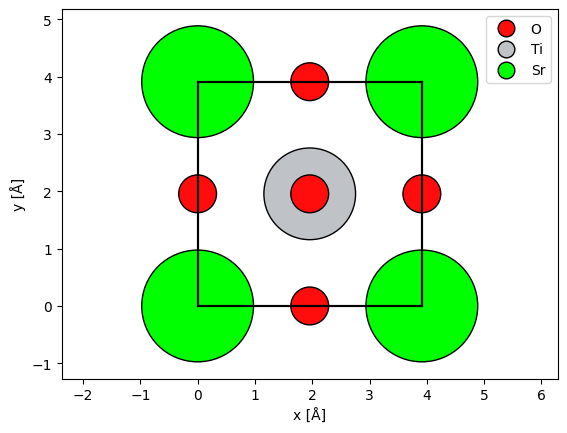

In [214]:
#visualizing the structure with abtem
abtem.show_atoms(srtio3,
                 plane="xy",  # show a view perpendicular to the 'xy' plane
                scale=0.5,  # scale atoms to 0.5 of their covalent radii; default is 0.75
                 show_periodic=True, #shows structure periodically over the set structrure cube
                legend=True,  # show a legend with the atomic symbols
                )

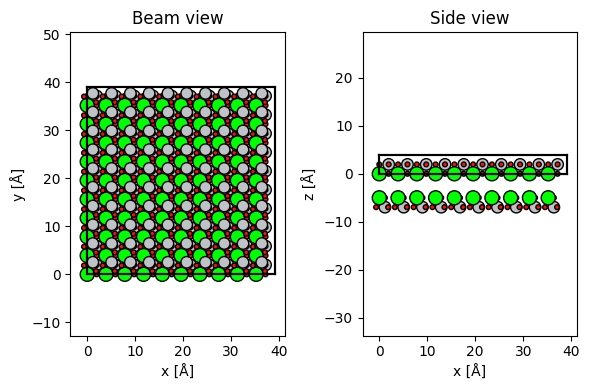

In [259]:
#repeating the ase structure:
repeated_srtio3 = srtio3_double * (10, 10, 1) #strucutre is repeated 2 time in xy directino and 6 times in z direction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
abtem.show_atoms(repeated_srtio3, ax=ax1, title="Beam view")
abtem.show_atoms(repeated_srtio3, ax=ax2, plane="xz", title="Side view")
fig.tight_layout();

In [260]:
potential = abtem.Potential(
    repeated_srtio3,
    sampling=0.05,
    parametrization="lobato",
    slice_thickness=1,
    projection="finite",
)

[########################################] | 100% Completed | 10.20 s


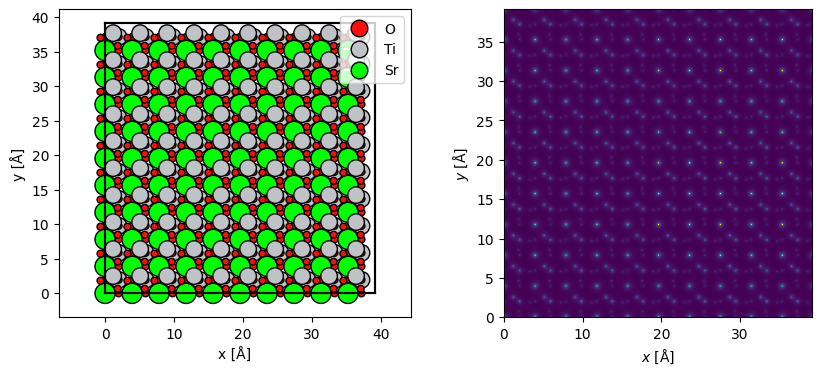

In [261]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

abtem.show_atoms(repeated_srtio3, ax=ax1, legend=True)

visualization = (potential.build() * 0.1).show(ax=ax2);

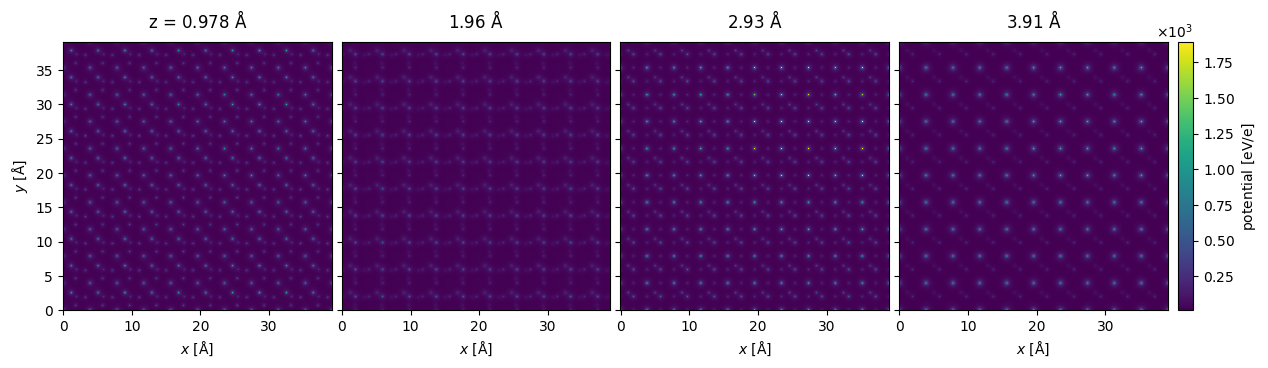

In [262]:
visualization = potential[:5].show(
    project=False,
    explode=True,
    figsize=(14, 5),
    common_color_scale=True,
    cbar=True,
)